# APMO Results 2019: Reading, merging, cleaning and results report

In 2019, the APMO results were sent using an Excel file, which improved the data consistancy. This is a notebook to treat the received files and create a clean scoretable.

The raw data files contain personal information of the contestants, like birthdate and school. For privacy, we do not make these files public, and all the DataFrame readings avoid these entries.

## Imports and reading

We use some standard packages for data manipulation and analysis

- For data scrapping and manipulation we use `pandas`. We have to load the results sent by each country representative. They are saved in the `sent_by_country/2019/` directory with filenames like 'country.xls' or 'country.xlsx' (as some countries send files using different versions of Excel). 
- To avoid typing all filenames we use `glob`.
- For statistical calculations we use `numpy`.
- For visualization, we use matplotlib. For a nicer formatting, we use `seaborn`.
- Finally, to create reports for web display we create `json` reports.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json

# For reusability, we set a year varible
year=2019

# Import the Excel files that we received from the countries
files=glob.glob('sent_by_country/%s/*.xls*' % year)

# Optional sanity check for file count. Compare with the number of participating countries.
# print(len(files))

## Reading and merging

We create a list of dataframes to merge, one from each country. To keep the country information, we add to each dataframe a `'Country'` column, which will have a nice formatting for later HTML use. Here we are assuming that the Excel with the results from each country is named with the format `Name_of_Country.xlsx`.

From each file we go to the 1st table (the only one), and we load at most 10 students (some countries like to add more students to the list, but a maximum of 10 is allowed by the APMO Regulations). The `skiprows` and `usecols` parameters are chosen to match the Excel file format.

The goal here is to create the first version of the data frame `st` that stands for 'score table'.

In [2]:
df_list=[]

for filename in files:
    country=pd.read_excel(filename, sheet_name=0, skiprows=range(0,7), usecols=range(0,10), nrows=10)
    country_name=filename.split('/')[2].split('.')[0].replace('_',' ')
    country['Country']=country_name
    df_list.append(country)
    
# We concatenate and reset the index for clean data
st=pd.concat(df_list, sort=False).reset_index().drop('index', axis=1)

# The loading is done. We check the table for missing values
st.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
Rank          399 non-null float64
Last Name     357 non-null object
First Name    357 non-null object
M/F           357 non-null object
P1            357 non-null float64
P2            356 non-null float64
P3            356 non-null float64
P4            351 non-null float64
P5            355 non-null float64
Total         357 non-null float64
Country       400 non-null object
dtypes: float64(7), object(4)
memory usage: 34.5+ KB


## Cleaning

Among the 400 total entries, there is one missing rank. There are many missing values in `First Name`, `Last Name` and `Rank` fields. We also have some missing values at some problem scores that we need to check out.

We start by checking check the `NA` entries for rank, first name and last name. They probably indicate that less than 10 contestants participated from a country.

In [3]:
for column in ['Rank', 'First Name']:
    null_values=st[column].isnull()
    print('Checking NA values for %s\n' % column)
    print(st[null_values])
    print()

Checking NA values for Rank

     Rank Last Name First Name  M/F  P1  P2  P3  P4  P5  Total   Country
189   NaN       NaN        NaN  NaN NaN NaN NaN NaN NaN    NaN  Pakistan

Checking NA values for First Name

     Rank Last Name First Name  M/F  P1  P2  P3  P4  P5  Total  \
54    5.0       NaN        NaN  NaN NaN NaN NaN NaN NaN    NaN   
55    6.0       NaN        NaN  NaN NaN NaN NaN NaN NaN    NaN   
56    7.0       NaN        NaN  NaN NaN NaN NaN NaN NaN    NaN   
57    8.0       NaN        NaN  NaN NaN NaN NaN NaN NaN    NaN   
58    9.0       NaN        NaN  NaN NaN NaN NaN NaN NaN    NaN   
59   10.0       NaN        NaN  NaN NaN NaN NaN NaN NaN    NaN   
88    9.0       NaN        NaN  NaN NaN NaN NaN NaN NaN    NaN   
89   10.0       NaN        NaN  NaN NaN NaN NaN NaN NaN    NaN   
162   3.0       NaN        NaN  NaN NaN NaN NaN NaN NaN    NaN   
163   4.0       NaN        NaN  NaN NaN NaN NaN NaN NaN    NaN   
164   5.0       NaN        NaN  NaN NaN NaN NaN NaN NaN    NaN 

Indeed, these correspond to countries with fewer than 10 participating students. There is no useful information here, and we may safely drop all these rows and continue inspecting the remaining NA values.

In [4]:
participants=st['First Name'].notna()
st=st[participants]
st.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357 entries, 0 to 399
Data columns (total 11 columns):
Rank          357 non-null float64
Last Name     357 non-null object
First Name    357 non-null object
M/F           357 non-null object
P1            357 non-null float64
P2            356 non-null float64
P3            356 non-null float64
P4            351 non-null float64
P5            355 non-null float64
Total         357 non-null float64
Country       357 non-null object
dtypes: float64(7), object(4)
memory usage: 33.5+ KB


Now we inspect the null values in the problem columns.

We define `prob_cols`, a list that contains all the column names related to problem scores. We will use this list various times later on.

In [5]:
# Note that here we are defining the 
prob_cols=['P%s' % str(j) for j in range(1,6)]

for prob in prob_cols:
    print('Entries with missing values for %s' % prob)
    print(st[st[prob].isnull()])
    print()

Entries with missing values for P1
Empty DataFrame
Columns: [Rank, Last Name, First Name, M/F, P1, P2, P3, P4, P5, Total, Country]
Index: []

Entries with missing values for P2
     Rank Last Name First Name M/F   P1  P2   P3  P4  P5  Total Country
160   1.0     Modes       Luis   M  7.0 NaN  7.0 NaN NaN   14.0  Panama

Entries with missing values for P3
     Rank Last Name First Name M/F   P1   P2  P3  P4  P5  Total Country
161   2.0  Marciaga   Leonardo   M  7.0  1.0 NaN NaN NaN    8.0  Panama

Entries with missing values for P4
     Rank Last Name First Name M/F   P1   P2   P3  P4   P5  Total Country
160   1.0     Modes       Luis   M  7.0  NaN  7.0 NaN  NaN   14.0  Panama
161   2.0  Marciaga   Leonardo   M  7.0  1.0  NaN NaN  NaN    8.0  Panama
172   3.0   Brandon       Wang   M  7.0  7.0  3.0 NaN  7.0   24.0     USA
176   7.0     Frank        Han   M  7.0  6.0  0.0 NaN  6.0   19.0     USA
177   8.0      Eric        Gan   M  7.0  7.0  1.0 NaN  3.0   18.0     USA
291   2.0   Zaharov

So, some representatives are making a distinction between a student with 0 points, but who handed in the problem, and a student who did not hand in the problem, in which case they wrote `NA`. We see that this is consistent with the rest of the content of the files of Panama, USA and Russia. We may then safely assume that these `NA` correspond to a score of 0.

Also, note that the scores and rank are of type `float`. It is more natural for them to be of type `int`. Now that we do not have any more `NA`, it is a good time to perform the conversion.

Now we have certainty about the number of contestants and participating countries. We store them in variables `num_contestants` and `num_countries`. We will use them for the JSON report.

In [6]:
st=st.fillna(0)

# Remember prob_cols contains 
for column in prob_cols + ['Rank', 'Total']:
    st[column]=st[column].astype(int)
st.info()

# The first info we can send later on to the JSON report
num_contestants=st.shape[0]
num_countries=len(st['Country'].unique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357 entries, 0 to 399
Data columns (total 11 columns):
Rank          357 non-null int64
Last Name     357 non-null object
First Name    357 non-null object
M/F           357 non-null object
P1            357 non-null int64
P2            357 non-null int64
P3            357 non-null int64
P4            357 non-null int64
P5            357 non-null int64
Total         357 non-null int64
Country       357 non-null object
dtypes: int64(7), object(4)
memory usage: 33.5+ KB


We have dealt with all the `NA` entries. We perform some additional sanity checks:

- Verify that the total column matches the sum of the problem columns
- Verify that each student's rank is at most 10

In [7]:
# Verify sum of columns and total value
print('Test: Sums of problem scores equal total values')
print((st[prob_cols].sum(axis=1)==st['Total']).all())

print('Test: Each student rank is correct')
print(st.Rank.max()<=10 and st.Rank.min()>=0)

Test: Sums of problem scores equal total values
True
Test: Each student rank is correct
True


Now we have a complete, clean and tidy score table. Each row is an observation and it has all the important information about APMO scores. It is a good idea to save this file. Not only we will use it for further use, but it is also a valuable candidate for open information.

Before that we just make a couple of stylistic changes. We name the columns with lowercase letters and we reorder them to place the coutry name first, which is more natural.

In [8]:
st.columns = ['rank', 'last', 'first', 'sex', 'p1', 'p2', 'p3', 'p4', 'p5', 'total', 'country']
st=st[['country', 'rank', 'last', 'first', 'sex', 'p1', 'p2', 'p3', 'p4', 'p5', 'total']].sort_values(['country','rank'])
st.to_excel('data_clean/scoretable-%s-clean.xlsx' % year,index=False)
st.head()

,country,rank,last,first,sex,p1,p2,p3,p4,p5,total
250,Argentina,1,LIWSKI,EMILIANO,M,7,6,0,0,7,20
251,Argentina,2,CARRANZA VELEZ,MATEO,M,7,7,0,0,3,17
252,Argentina,3,DI ZANZO,BRUNO,M,7,7,1,0,0,15
253,Argentina,4,RAIMUNDEZ,MATÍAS EZEQUIEL,M,7,7,0,0,0,14
254,Argentina,5,MASLIAH,JULIAN,M,7,7,0,0,0,14


## Medal cut-offs determination

Now that we know the data is clean, we can proceed to determine awards according to APMO regulations. The medal cut-offs are given under the following rules:

    * Maximum total number of award certificates $(n+1)/2$, where $n$ is the total number of APMO contestants. When ties occur, increase number.

    Let $m$ be the mean APMO score and $s$ the standard deviation of all the APMO scores

    * Scores for gold awards at least $m+s$
    * Scores for silver awards at least $m+\frac{s}{3}$
    * Scores for bronze awards at least $m-\frac{s}{3}$

    Additionally, for a particular country the number of
    * Gold awards must be at most 1,
    * Gold + silver awards must be at most 3, and
    * Gold + silver + bronze awards must be at most 7.

In other words, for a student to be awarded a gold medal (silver, bronze), he must be above the cut-off, and have rank better than 1 (3, 7, respectively) in his own country.

    A certificate of Honourable Mention will be awarded to any contestant who has not received an Award certificate but who has performed creditably according to some criteria

We start by calculating the mean and standard deviation. We save them to variables `meanAPMO`, `stdAPMO` that we also add to the final JSON report.

In [9]:
meanAPMO = np.mean(st.total)
stdAPMO = np.std(st.total)

print(meanAPMO, stdAPMO)

11.747899159663865 6.865925062147047


We calculate the medal cut-offs. They will also be included in the report.

In [10]:
gold = meanAPMO + stdAPMO
silver = meanAPMO + stdAPMO/3
bronze = meanAPMO - stdAPMO/3
print(gold, silver, bronze)

18.613824221810912 14.036540847046213 9.459257472281516


We construct an auxiliary function to which we pass the rank of a student and its problem scores. It returns the prize that should be awarded.

In [11]:
# A student might satisfy the conditions for different medals, but note
# how the logic of the if clause awards the best one, as it should.

def award(result):
    scores, rank=result[0:5],result[5]
    total = sum(scores)
    if total >= gold and rank <= 1:
        return('Gold')
    elif total >= silver and rank <=3:
        return('Silver')
    elif total >= bronze and rank <=7:
        return('Bronze')
    elif max(scores)==7:
        return 'Hon. Men.'
    else:
        return ''

We add the award column according to the award-giving rules. It is a good practice to convert the `'Award'` column now to a categorical one. It will help us later when pivoting to get a correct order on the importance of medals.

As a sanity check, we take a look at the 15 best students. This is a good indicator that we are not giving too many of the same to any country. 

In [12]:
prob_cols = list(map(lambda x: x.lower(), prob_cols))
st['award'] = st[prob_cols+['rank']].apply(award, axis='columns')

st['award'] = pd.Categorical(st['award'], 
                                       categories=['Gold', 'Silver', 'Bronze', 'Hon. Men.', ''], ordered=True)

# We peek at the best students
st.sort_values(['total','rank'], ascending=[False,True]).head(15)

,country,rank,last,first,sex,p1,p2,p3,p4,p5,total,award
150,Republic of Korea,1,Cho,Youngjun,M,7,7,7,6,1,28,Gold
330,Singapore,1,Ng,Yu Peng,M,7,7,7,0,7,28,Gold
170,USA,1,Edward,Wan,M,7,7,7,0,7,28,Gold
151,Republic of Korea,2,Noh,Taeyeong,M,7,7,7,0,7,28,Silver
370,Japan,1,Naoki,Kuroda,M,7,7,7,0,6,27,Gold
152,Republic of Korea,3,Kim,Jimin,M,7,7,7,0,6,27,Silver
153,Republic of Korea,4,Kim,Seojin,M,7,7,5,0,7,26,Bronze
290,Russia,1,L'vov,Aleksej,M,7,7,7,0,4,25,Gold
10,Thailand,1,Lapate,Papon,M,7,7,4,0,7,25,Gold
331,Singapore,2,Boo,Tse Yang Lucas,M,7,7,0,7,4,25,Silver


So far so good. Note that the competition was quite hard, as no student received more than 28 points. Also, looking at the top students we realize that Problem 4 was probably too hard.

We still have to verify that we are not giving to many awards according to the first rule

In [13]:
print('Test: Number of awards do not exceed half the number of participants')
num_awards=sum((st.award == 'Gold') | 
          (st.award == 'Silver') | 
          (st.award == 'Bronze'))
print("We have %s awards and %s contestants" % (num_awards, num_contestants))
print(num_awards<=(num_contestants+1)/2)

Test: Number of awards do not exceed half the number of participants
We have 168 awards and 357 contestants
True


## Generation of reports: general alphabetic, general ranked, by country, by problem

At the end of each APMO, the organizing country provides the following reports:
- A full scoretable with 
- A table of results for each country
- A general table of results by country, which includes the number of participants, total sum, and number of awards for each participating country. This is provided both sorted alphabetically, and by rank (determined by the total sum of scores).
- An analysis of the difficulty for each problem
- Medalists for each category

From APMO 2019 onwards we are going to change the way we present the results. Before this, we used to create HTML files and have a static page. Now we want the results to be loaded dynamically. For this, we will generate JSON reports.

We start by saving the scoretable with awards that we already have.

In [14]:
st.to_csv('reports/score_awards_%s.csv' % year, index=False)

We will not create individual reports from each country. To report them, we will load the csv file above for each country that we have, filter it with `pandas` and pass it to `flask`.

Now we create the scoretable by countries. We split this into two parts, by first creating a pivot table to count medals per country, and by creating a group agregation. We then merge both dataframes to get the desired table.

In [15]:
# First we create a pivot table to count the medals per country
medals_country = st[['rank','country','award']].pivot_table(index='country', 
                                                             columns='award', 
                                                             aggfunc='count', fill_value=0)
# We clean the multindex
medals_country.columns = medals_country.columns.droplevel()
medals_country

award,Gold,Silver,Bronze,Hon. Men.,
country,,,,,
Argentina,1,2,4,3,0
Bangladesh,0,1,4,5,0
Brazil,1,2,4,3,0
Cambodia,0,0,0,4,6
Canada,1,2,4,3,0
Colombia,0,1,2,2,5
Costa Rica,0,0,1,1,6
Ecuador,0,0,0,1,9
El Salvador,0,1,1,0,5


In [16]:
# Now we calculate the total number of students and the total sum of scores for each country

totals_country = st[['rank', 'total', 'country']].groupby('country').agg({'rank':'count','total':'sum'})
totals_country['total']=totals_country.total.astype(int) 
totals_country

,rank,total
country,,
Argentina,10,141
Bangladesh,10,109
Brazil,10,156
Cambodia,10,48
Canada,10,162
Colombia,10,72
Costa Rica,8,42
Ecuador,10,12
El Salvador,7,41


In [17]:
# We merge everything into a final report with all the information

report_country = pd.concat([totals_country, medals_country], axis=1).drop('', axis=1)
report_country.columns=['# of Contestants', 'Total Score', 'Gold Awards', 'Silver Awards', 'Bronze Awards', 'Honorable Mentions']
report_country.index.name='Country'
report_country.reset_index(inplace=True)
report_country.to_html('reports/by_country_%s.html' % year, index=False, border=0,
                           classes="table table-sm table-striped")
report_country

,Country,# of Contestants,Total Score,Gold Awards,Silver Awards,Bronze Awards,Honorable Mentions
0,Argentina,10,141,1,2,4,3
1,Bangladesh,10,109,0,1,4,5
2,Brazil,10,156,1,2,4,3
3,Cambodia,10,48,0,0,0,4
4,Canada,10,162,1,2,4,3
5,Colombia,10,72,0,1,2,2
6,Costa Rica,8,42,0,0,1,1
7,Ecuador,10,12,0,0,0,1
8,El Salvador,7,41,0,1,1,0
9,Guatemala,2,10,0,0,0,0


In [18]:
# Now we prepare the report of countries by rank, which we get easily from this table
report_country_rank = report_country.sort_values('Total Score', 
                                                 ascending=False).reset_index().drop(['index'], axis=1)
report_country_rank.index = report_country_rank.index.map(lambda x:x+1)
report_country_rank.index.name='Rank'
report_country_rank.reset_index(inplace=True)
report_country_rank.to_html('reports/by_country_ranked_%s.html' % year, index=False, border=0,
                           classes="table table-sm table-striped")
report_country_rank

,Rank,Country,# of Contestants,Total Score,Gold Awards,Silver Awards,Bronze Awards,Honorable Mentions
0,1,Republic of Korea,10,240,1,2,4,3
1,2,USA,10,212,1,2,4,3
2,3,Singapore,10,202,1,2,4,3
3,4,Thailand,10,200,1,2,4,3
4,5,Russia,10,194,1,2,4,3
5,6,Islamic Republic of Iran,10,193,1,2,4,3
6,7,Japan,10,167,1,2,4,2
7,8,Indonesia,10,167,1,2,4,3
8,9,Canada,10,162,1,2,4,3
9,10,Taiwan,10,159,1,2,4,3


Finally, we create the lists of awards. We will save this info in the JSON report

In [19]:
g_a=(st.award=='Gold')
s_a=(st.award=='Silver')
b_a=(st.award=='Bronze')
h_m=(st.award=='Hon. Men.')

name_country=st['first'].str.title() + ' ' + st['last'].str.title()+ ' (' +st.country + ')'
g_awd=list(name_country[g_a])
s_awd=list(name_country[s_a])
b_awd=list(name_country[b_a])
h_men=list(name_country[h_m])

(Deprecated) We turn our attention to the reports by country. These are, basically, the ones that we received initially. However, we have already cleaned some problems and awarded prizes. Also, for now we are not reporting on the gender of participants, so we drop that column from the final reports. Since this is data for display, we capitalize the column names again.

In [20]:
# for value in st.country.unique():
#     country_df=st.loc[st.country==value,:]
#     country_df=country_df.drop(['country','sex'],axis=1)
#     country_df.columns=['Rank', 'Last Name', 'First Name', 'P1', 'P2', 'P3', 'P4', 'P5', 'Total', 'Award']
#     country_df.to_html('reports/report_%s_2019.html' % value.lower().replace(' ','_'), index=False, border=0,
#                            classes="table table-sm table-striped")
#     print(country_df.head())

## Plots and JSONs

Now we create some plots and JSONs to help with the yearly reports. We want to create:
- A histogram of total scores
- A histogram of scores by problem
- A JSON with the general info of the competition

We start with the histogram for all APMO scores

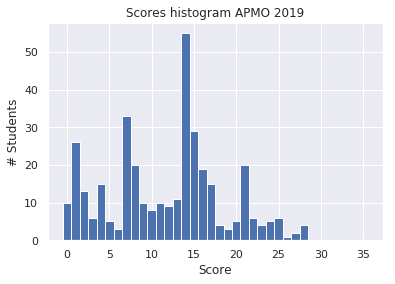

In [21]:
sns.set(color_codes=True)

plt.hist(st.total, bins=range(0,37), align='left')
plt.xlabel('Score')
plt.ylabel('# Students')
plt.title('Scores histogram APMO %s' % year)
plt.savefig('reports/histogram %s.png' % year,dpi=120,transparent=True)
plt.show()

Now we create histograms for each problem. We use once again the `prob_cols` variable. We use `.title()` for better formatting

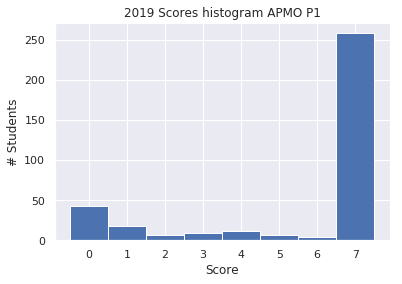

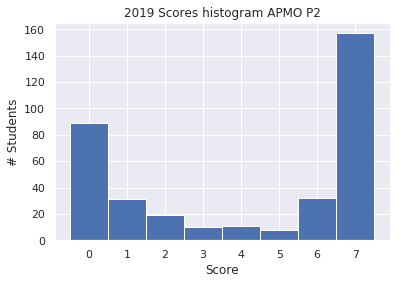

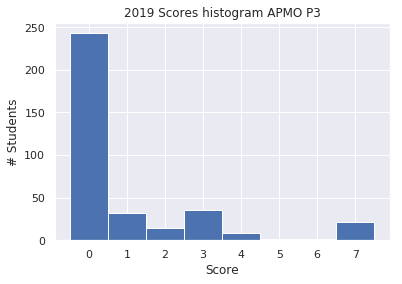

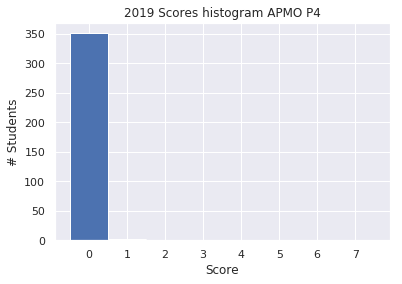

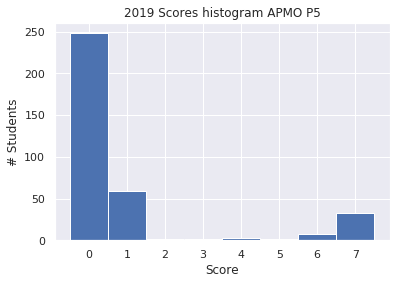

In [25]:
for prob in prob_cols:
    plt.hist(st[prob], bins=range(0,9), align='left')
    plt.xlabel('Score')
    plt.ylabel('# Students')
    plt.title('%s Scores histogram APMO %s'% (year, prob.title()))
    plt.savefig('reports/histogram_%s_%s.png' % (prob, year),dpi=120,transparent=True)
    plt.show()

Finally, we export the information of the competition to JSON format. This will be later read by a `flask` app and sent to a `jinja2` template.

In [27]:
competition_info={'num_contestants':num_contestants, 'num_countries':num_countries, 'num_awards':num_awards,
                 'gold':int(np.ceil(gold)), 'silver':int(np.ceil(silver)), 'bronze':int(np.ceil(bronze)),
                 'mean':meanAPMO, 'std':stdAPMO, 'g_awd':g_awd, 's_awd':s_awd, 'b_awd':b_awd, 'h_men':h_men}

# We calculate the mean and std for each problem
p_means = [np.mean(st[prob]) for prob in prob_cols]
p_stds = [np.std(st[prob]) for prob in prob_cols]
competition_info['p_means']=p_means
competition_info['p_stds']=p_stds

# We dump the JSON
    
with open('reports/apmo_%s_info.json' % year, 'w') as fp:
    json.dump(competition_info, fp)